# Iterative techniques in Linear Algebra
Just as iterative techniques can be used to find fixed points of real funtions, they can often be used to solve linear systems. In this notebook, we briefly introduce the Jacobi method for solving linear systems and the power method for finding eigensystems. 

Both involve iterative mulitplication by a matrix and, as a result, are often applied to large, sparse systems. Here's an example of a sparse matrix that we'll use as an example later. Note that `np.diag` is a diagonal matrix constructor and `scipy.sparse.diags` is a sparse version. It constructs the same matrix, but is stored in a sparse format.

In [1]:
from scipy.sparse import diags

n = 8
L = diags([1, -2, 1], [-1, 0, 1], shape=(n,n))
L

<8x8 sparse matrix of type '<class 'numpy.float64'>'
	with 22 stored elements (3 diagonals) in DIAgonal format>

We can convert it to an ordinary array for display purposes, if we want.

In [2]:
L.toarray()

array([[-2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., -2.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1., -2.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -2.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -2.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -2.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -2.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -2.]])

This matrix (sometimes multiplied by a constant depending on $n$) is called the Laplacian matirx. When we study numerical differentiation, we'll see that it is closely related to the second derivative and that computations involving it are, therefore, related to second order differential equations.

Here are a few more imports we'll need:

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import solve, eig, norm
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve, eigs

## The Jacobi method
### The general scheme
We wish to solve $Mx=b$ using an *iterative* technique. By analogy with the tricks we learned for finding fixed points of functions, we'll need an initial seed vector $x_1$ and some *contractive* linear operation whose fixed point is a solution to $Mx=b$. Often, such an operation can be found by rewriting the system in terms of a non-singular matrix $Q$ as
$$Qx=(Q-M)x+b.$$
This suggest that we define $x_{k+1}$ in terms of $x_k$ by
$$Qx_{k+1} = (Q-M)x_k + b.$$
Of course, for the technique to work, we need the system $Qx=b$ to be very easy to solve. Possibilities include $Q$ matrices that are triangular or even diagonal.
### Richarson iteration
Perhaps $Q=I$ is the easiest possible choice of $Q$. This leads to Richarson iteration which basically asks us to iterate the vector recurrence
$$x_{k+1} = (I-M)x_k + b.$$
Here's an example.

In [4]:
M = np.array([
    [1,1/2,1/3],
    [-1/3,1,1/2],
    [-1/3,-1/2,1]
])
b = [1,2,3]
I = np.identity(len(M))
xi = np.ones(len(M))
for i in range(51): 
    xi = (I - M).dot(xi) + b
    if i%10 == 0:
        print(xi)
M.dot(xi)

[ 0.16666667  1.83333333  3.83333333]
[-0.21919293  0.3174603   3.06394147]
[-0.22319972  0.37198033  3.1135086 ]
[-0.22215067  0.37033715  3.11100579]
[-0.22222613  0.37037014  3.11111516]
[-0.22222204  0.37037045  3.11111098]


array([ 1.00000017,  1.99999995,  2.99999977])

I guess the residual looks good.

### Convergence
Richardson iteration doesn't often converge. More generally, choosing $Q$ to both guarantee convergence and make the system $Qx$ easy to deal with can be tricky. If we write the iterative formula as 

$$x_{k+1} = Q^{-1}((Q-M)x_k + b) = (I-Q^{-1}M)x_k+Q^{-1}b,$$

then we see that we can expect convergence whenever $I-Q^{-1}M$ is contractive or, equivalently, all its eigenvalues are less than one in magnitude. The maximum of the absolute values of the eigenvalues is sometimes called the *spectral radius*. The exact computation of the spectral radius is a challenging problem in its own right, but there is a simple bound provided by Gershgorin's theorem:

**Theorem**: All the eigenvalues of the $n$-dimensional $M=(m_{ij})$ are contained in the union of the disks $D_{r_i}(m_{ii})$, where $r_i$ is the sum of the absolute values of the off-diagonal entries of the $i^{\text{th}}$ row:
$$r_i = \sum_{\substack{j=1\\j\neq i}}^n |a_{ij}|.$$

In the example of Richardson iteration that we just did, we are iterating the matrix

$$I - M = \left(\begin{array}{ccc}
  0 & -1/2 & -1/3 \\
  1/3 & 0 & -1/2 \\
  1/3 & 1/2 & 0
\end{array}\right)$$

and Gersgorin's theorem Guarantees that the eigenvalues are all less than $1/2+1/3=5/6<1$ in magnitude. Thus, Richardson's iteration was guaranteed to converge.

### Jacobi's iteration
Let $D$ denote the matrix whose off diagonal elements are zero and whose diagonal elements agree with those of $M$. If we take $Q=D$ in our general recurrence equation, we get

$$Dx_{k+1} = (D-M)x_k + b = b-(M-D)x_k.$$

This is the Jacobi iteration and the Gershgorin disks can be used to prove that it is convergent whenever $M$ is diagonally dominant, i.e. the each diagonal term is greater than the sum of the absolute values of the terms in it's row.  Here's an example:


In [5]:
M = np.array([
    [5,-2,1,0,1],
    [1,6,2,-1,1],
    [0,3,7,2,0],
    [1,0,2,4,0],
    [1,-1,0,2,5]
])
b = [1,2,-1,-2,0]

d = np.diag(M) # Vector for division
D = np.diag(d) # Matrix with d on the diagonal
MM = M-D

xi = np.ones(len(M))
for i in range(30):
    xi = (b-MM.dot(xi))/d
    if i%5 == 0:
        print(xi)
M.dot(xi)

[ 0.2        -0.16666667 -0.85714286 -1.25       -0.4       ]
[ 0.26079382  0.21399067 -0.04517561 -0.49241997  0.21836298]
[ 0.25381653  0.19523123 -0.07820714 -0.52652418  0.19755806]
[ 0.25409482  0.19604071 -0.07677026 -0.52504459  0.1984648 ]
[ 0.25408299  0.19600581 -0.07683259 -0.52510852  0.19842547]
[ 0.25408351  0.19600732 -0.07682989 -0.52510575  0.19842717]


array([  1.00000001e+00,   2.00000005e+00,  -9.99999903e-01,
        -1.99999994e+00,   4.38165437e-08])

Here's alternative way to think of the Jacobi itertion obtained by writing out the matrix equation $Mx=b$ longhand to get the $n$ equations
$$\sum_{j=1}^n m_{ij}x_{j} - b_i.$$
If we solve for $x_i$, we get
$$x_i = (b_i - \sum_{\substack{j=1\\j\neq i}}^n m_{ij}x_j)/m_{ii},$$
which is exactly where the Jacobi iteration comes from.

### A sparse example
As already mentioned, the Laplacian matrix is gives us a numerical approximation to the second derivative.

In [6]:
n = 9
L = diags([1,-2,1],[-1,0,1],shape=(n,n))*(n+1)**2
L.toarray()

array([[-200.,  100.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [ 100., -200.,  100.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,  100., -200.,  100.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,  100., -200.,  100.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,  100., -200.,  100.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,  100., -200.,  100.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,  100., -200.,  100.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,  100., -200.,  100.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,  100., -200.]])

Let's solve $Lx=b$, where each entry of $b$ is $-1$. This should be analogous to solving $y'' = -1$.

In [7]:
L = L.tocsr() # Better format for multiplication
b = -np.ones(n)
sol = spsolve(L,b)
sol

array([ 0.045,  0.08 ,  0.105,  0.12 ,  0.125,  0.12 ,  0.105,  0.08 ,
        0.045])

If this approximates $y''=-1$, I guess it oughtta look like an upside down parabola somehow.

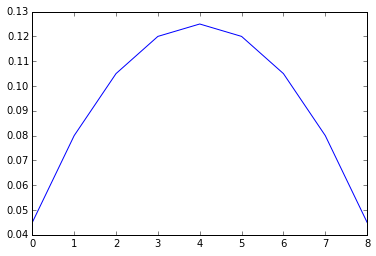

In [8]:
plt.plot(sol)

Crazy! Let's smooth it out by using more terms.

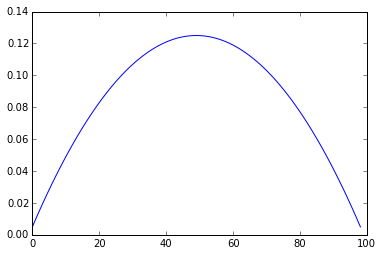

In [9]:
n = 99
L = diags([1,-2,1],[-1,0,1],shape=(n,n))*(n+1)**2
L = L.tocsc()
b = -np.ones(n)
sol = spsolve(L,b)
plt.plot(sol)

## The power method for eigenvalues
If we want to iterate a linear function, what could be more natural than iterating $x\to Mx$? Let's suppose that such a process in fact converges. Then the limit $x$ must satisfy $Mx=x$ - put another way, $x$ is an eigenvector of $M$ with eigenvalue $1$. I guess that's a rather unlikely occurrence, but what if we normalize at each step? Thus we map $x\to Mx/\|Mx\|$.

Let's try it with a postive matrix so that we are guaranteed a dominant eigenvalue.

In [10]:
from numpy.random import randint, seed
seed(1)
M = randint(1,5,(9,9))
x = np.ones(9)
for i in range(10):
    x = M.dot(x)
    x = x/np.linalg.norm(x)
x

array([ 0.37068839,  0.2618479 ,  0.34081889,  0.33168157,  0.38030617,
        0.2298741 ,  0.41414042,  0.32635724,  0.30390689])

Let's see how $Mx$ compares to $x$.

In [11]:
M.dot(x)/x

array([ 21.49283762,  21.4928376 ,  21.49283763,  21.49283767,
        21.49283762,  21.49283766,  21.49283764,  21.49283761,  21.49283763])

That tells me that our limit is an eigenvector with eigenvalue about 21.5.

### What's the limit?
Let's suppose that the $n\times n$ matrix $M$ has eigenvalues $\lambda_i$ with corresponding eigenvectors $v_i$ for $i=1,\ldots,n$. If we allow for complex eigenvalues, there should be a complete set of eigenvectors. Let's suppose also that there is one eigenvalue, which we assume WLOG to be $\lambda_1$, whose absolute value is larger than the absolute values of all the others. Since complex eigenvalues come in complex conjugate pairs, this implies that $\lambda_1$ is real.

Now, given $x\in\mathbb R^n$, write it in terms of the eigen-basis:
$$x = c_1 v_1 + c_2 v_2 + \cdots + c_n v_n.$$
Then multiplying by $A$ a total of $k$ times,
$$\begin{align}
A^k x &= c_1\lambda_1^k v_1 + c_2\lambda_2^k v_2 + \cdots + c_n\lambda_n v_n \\
 &= \lambda_1^k(c_1 v_1 + c_2(\lambda_2/\lambda_1)^k v_2 + \cdots + c_n(\lambda_n/\lambda_1)^k v_n)
\end{align}.$$
Thus all portions other than the dominant portion tend to zero.

### `eigs`
`eigs` is SciPy's sparse eigensystem function. Let's use it to compute a few eigenvalues and eigenvectors of the Laplacian matrix. The shift, specified by `sigma=0` here specifies that we are looking for small eigenvalues, rather than large ones.

In [12]:
n = 999
L = diags([1,-2,1],[-1,0,1],shape=(n,n))*(n+1)**2
L = L.tocsc()
vals, vecs = eigs(L,5,sigma = 0)
vals

array([  -9.86959628+0.j,  -39.47828773+0.j,  -88.82578210+0.j,
       -157.91159237+0.j, -246.73503668+0.j])

Might not look so exciting, until you realize that the eigenfunctions of the linear operator $y\to y''$ over the unit interval are related to the trig functions. For example, 

$$\frac{d^2}{dx^2} \sin(\pi x) = -\pi^2 \sin(\pi x).$$

In fact, that smallest eigenvalue yields an approximation to $\pi$!

In [13]:
np.sqrt(-vals[0])

(3.1415913616620377-0j)

And plots of the vectors look like trig functions.

/Users/mcmcclur/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


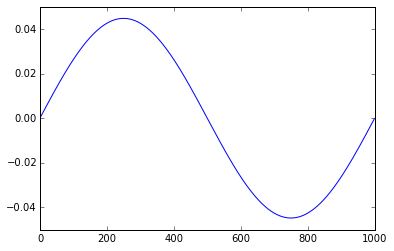

In [14]:
plt.plot(vecs[:,1])